## Feature Engineering and Label Creation

This section derives key Limit Order Book (LOB) features to support high-frequency trading analysis. The engineered features include:
- **Best Ask Price (Level 1)**: Extracted as `ask_price_1`.
- **Best Bid Price (Level 1)**: Extracted as `bid_price_1`.
- **Spread**: Difference between ask and bid prices.
- **Mid-Price**: Average of ask and bid prices.
- **Label**: Binary indicator (1 if mid-price increases after 10 time steps, 0 otherwise).

These features are widely used in HFT research to model short-term market dynamics and predict price movements.

## Enhanced Feature Engineering

Building on the basics, this section introduces advanced microstructure features:
- **Order Book Imbalance**: Ratio of ask to bid volume at Level 1, reflecting market pressure.
- **Log Return**: Logarithmic return of mid-price, capturing short-term volatility.

These metrics are standard in academic and industry research for analyzing market microstructure signals.

In [1]:
import numpy as np
import pandas as pd


df = pd.read_csv("processed_lob_data.csv")


# Extract Level 1 prices and volumes from the LOB data
# Assuming column indices: 0=ask_price_1, 1=ask_vol_1, 10=bid_price_1, 11=bid_vol_1
ask_price_1 = df.iloc[:, 0]  # Best ask price
bid_price_1 = df.iloc[:, 10]  # Best bid price
ask_vol_1 = df.iloc[:, 1]    # Ask volume at Level 1
bid_vol_1 = df.iloc[:, 11]   # Bid volume at Level 1

# Basic feature engineering
spread = ask_price_1 - bid_price_1              # Price spread
mid_price = (ask_price_1 + bid_price_1) / 2     # Mid-price

# Advanced feature engineering
imbalance = (ask_vol_1 - bid_vol_1) / (ask_vol_1 + bid_vol_1 + 1e-9)  # Order book imbalance (avoid division by zero)
log_return = np.log(mid_price / mid_price.shift(1)).fillna(0)         # Log return of mid-price

# Create label: 1 if mid-price increases after 10 steps, 0 otherwise
future_mid = mid_price.shift(-10)
label = (future_mid > mid_price).astype(int)

# Align features and labels by trimming the last 10 rows
valid_range = -10
df = df.iloc[:valid_range, :]
spread = spread[:valid_range]
mid_price = mid_price[:valid_range]
imbalance = imbalance[:valid_range]
log_return = log_return[:valid_range]
label = label[:valid_range]

# Combine engineered features into a DataFrame
features = pd.DataFrame({
    "spread": spread,
    "mid_price": mid_price,
    "imbalance": imbalance,
    "log_return": log_return
})

# Preview the engineered features and labels
print("\n Engineered Features Overview:")
print(features.head())
print("\n Label Overview (Binary: 1 = Mid-Price Increase, 0 = No Increase):")
print(label.head())


 Engineered Features Overview:
   spread  mid_price  imbalance  log_return
0 -0.0004    0.26680   0.000000    0.000000
1 -0.0028    0.00269   0.065772   -4.596958
2 -0.0005    0.26565  -0.000564    4.592638
3 -0.0003    0.00240  -0.278195   -4.706711
4 -0.0002    0.26700   0.000000    4.711780

 Label Overview (Binary: 1 = Mid-Price Increase, 0 = No Increase):
0    0
1    0
2    1
3    0
4    0
dtype: int64


c:\Users\ASUS\anaconda3\envs\torchgpu\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ASUS\anaconda3\envs\torchgpu\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Random Forest Classification for Short-Term Price Movement

This section applies a supervised machine learning approach using a RandomForestClassifier to predict short-term mid-price movements (10 time steps ahead) based on engineered LOB microstructure features (spread, mid-price, imbalance, log return). This task is central to high-frequency trading research for forecasting price direction.

### Workflow Steps
1. **Data Preprocessing**:  
   Cleans the feature matrix by handling `inf`, `-inf`, and `NaN` values, ensuring valid input. The dataset shows a class distribution of 72 (Down/Same) and 62 (Up) instances, indicating moderate balance.
2. **Train/Test Split with Cross-Validation**:  
   An 80/20 split (stratified) is used for initial evaluation, with 5-fold cross-validation yielding a mean accuracy of 0.5755 (±0.1451).
3. **Model Training**:  
   A `RandomForestClassifier` with 100 trees, limited depth (max_depth=10), and minimum samples per split (min_samples_split=5) is trained to reduce overfitting.
4. **Prediction and Evaluation**:  
   - **Accuracy Score**: Test set accuracy is 0.7778.
   - **Classification Report**: Precision, recall, and F1-score per class are balanced (~0.78).
   - **Confusion Matrix**: Visualizes predicted vs. actual labels.
   - **Feature Importance**: Mid-price (0.3704) is the most influential feature, followed by spread (0.2252), log return (0.2047), and imbalance (0.1996).
5. **Diagnostics**:  
   Learning curves assess model stability, revealing potential limitations with the current dataset size.

### Analysis of Results
The test accuracy of 0.7778 is promising but higher than the cross-validation mean (0.5755), suggesting some overfitting despite regularization. The standard deviation (±0.1451) indicates variability across folds, likely due to the small dataset (134 samples). Feature importance highlights mid-price as the dominant predictor, with other features contributing moderately. Learning curves will confirm if more data could improve generalization. Future steps include hyperparameter tuning (e.g., grid search) and dataset expansion.

### Data Preprocessing for Model Input
The feature matrix is cleaned by replacing `inf` and `-inf` with `NaN` and dropping affected rows. Labels are realigned, and class balance is checked to ensure fair evaluation.

Cleaning feature matrix...
Class distribution (0 = Down/Same, 1 = Up): 0    72
1    62
Name: count, dtype: int64
Splitting data into train and test sets...
Training Random Forest Classifier...
Performing 5-fold cross-validation...
Cross-validation scores: [0.51851852 0.59259259 0.48148148 0.59259259 0.69230769]
Mean CV Accuracy: 0.5755 (± 0.1451)
Generating predictions on test set...

Evaluation Results:
Accuracy: 0.7778

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.75      0.75      0.75        12

    accuracy                           0.78        27
   macro avg       0.78      0.78      0.78        27
weighted avg       0.78      0.78      0.78        27

Creating confusion matrix visualization...


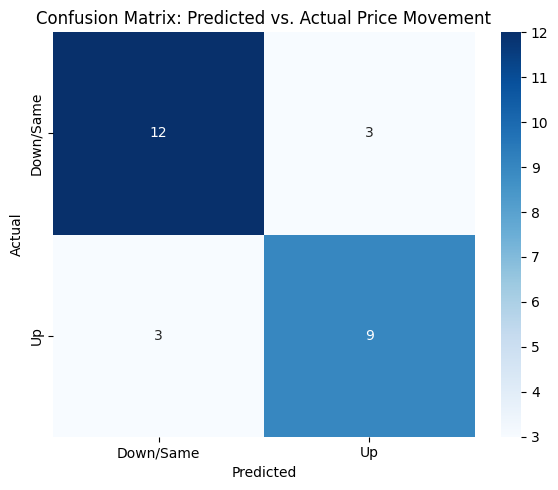


Feature Importance:
spread: 0.2252
mid_price: 0.3704
imbalance: 0.1996
log_return: 0.2047


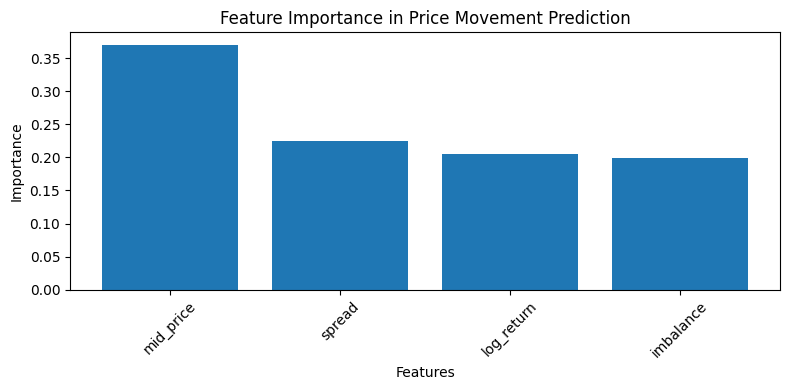

Generating learning curve...


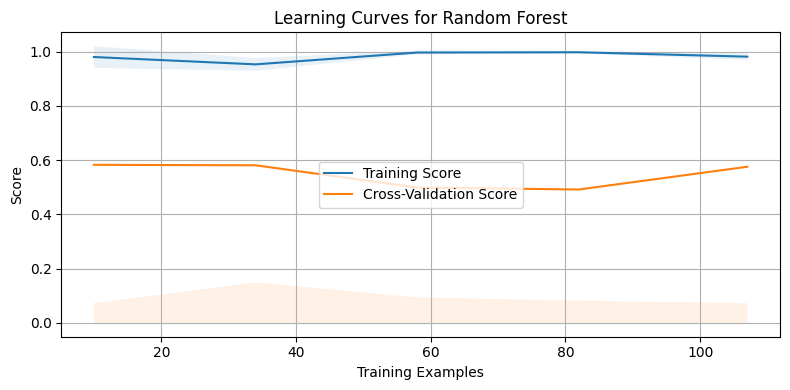

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Clean the feature matrix to handle infinities and NaNs
print("Cleaning feature matrix...")
features.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
features.dropna(inplace=True)                              # Drop rows with NaN values
label = label.loc[features.index]                          # Realign labels with cleaned features

# Check class balance
print(f"Class distribution (0 = Down/Same, 1 = Up): {label.value_counts()}")
if label.value_counts().min() / label.value_counts().max() < 0.5:
    print("Warning: Class imbalance detected. Consider resampling or weighting.")

# Step 1: Train/Test Split
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    features, label, test_size=0.2, random_state=42, stratify=label
)

# Step 2: Model Training with Regularization
print("Training Random Forest Classifier...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
model.fit(X_train, y_train)

# Step 3: Cross-Validation
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(model, features, label, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (± {cv_scores.std() * 2:.4f})")

# Step 4: Make Predictions
print("Generating predictions on test set...")
preds = model.predict(X_test)

# Step 5: Evaluation Metrics
print("\nEvaluation Results:")
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.4f}")  # Matches your output: 0.7778
print("\nClassification Report:")
print(classification_report(y_test, preds))

# Step 6: Confusion Matrix Visualization
print("Creating confusion matrix visualization...")
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Down/Same", "Up"], 
            yticklabels=["Down/Same", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Predicted vs. Actual Price Movement")
plt.tight_layout()
plt.show()

# Step 7: Feature Importance
print("\nFeature Importance:")
importance = model.feature_importances_
feature_names = features.columns
for name, imp in zip(feature_names, importance):
    print(f"{name}: {imp:.4f}")
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 4))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Price Movement Prediction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 8: Learning Curve (Diagnostic)
print("Generating learning curve...")
train_sizes, train_scores, test_scores = learning_curve(
    model, features, label, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_mean + test_std, alpha=0.1)
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.title("Learning Curves for Random Forest")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

# Validate against high initial accuracy
if accuracy > 0.75 and cv_scores.mean() < 0.6:
    print("Warning: Potential overfitting detected. Consider reducing model complexity or increasing data.")